In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [51]:
pd.set_option('display.max_colwidth', None)

数据集包含两种类型的数据。一个是“survey_data”，包含贡献者的调查结果。 另一个是“schema_data”，其中包含有关调查的信息、问题内容，问题的类型等。

In [52]:
survey_data = pd.read_csv("/input/stack-overflow-annual-developer-survey-2022/survey_results_public.csv")
schema_data = pd.read_csv("/input/stack-overflow-annual-developer-survey-2022/survey_results_schema.csv")

Currency data 是货币汇率，用于将不同的货币转为美元，以作为目标图表的标量化表示。

In [54]:
currency_data = pd.read_csv("/input/currencies-by-usd-with-gdp-and-gdp-per-capita/National Currencies Per US Dollar.csv", encoding="cp1252")

把 schema 图表分成若干 section 进行分析

In [55]:
section1_df = schema_data.iloc[schema_data[schema_data["qname"] == "S1"].index[0]: schema_data[schema_data["qname"] == "S2"].index[0]]

In [56]:
section2_df = schema_data.iloc[schema_data[schema_data["qname"] == "S2"].index[0]: schema_data[schema_data["qname"] == "S3"].index[0]]

In [57]:
section3_df = schema_data.iloc[schema_data[schema_data["qname"] == "S3"].index[0]: schema_data[schema_data["qname"] == "S4"].index[0]]

In [58]:
section4_df = schema_data.iloc[schema_data[schema_data["qname"] == "S4"].index[0]: schema_data[schema_data["qname"] == "S5"].index[0]]

In [59]:
section5_df = schema_data.iloc[schema_data[schema_data["qname"] == "S5"].index[0]: schema_data[schema_data["qname"] == "S6"].index[0]]

In [60]:
section6_df = schema_data.iloc[schema_data[schema_data["qname"] == "S6"].index[0]: schema_data[schema_data["qname"] == "S7"].index[0]]


In [61]:
section7_df = schema_data.iloc[schema_data[schema_data["qname"] == "S7"].index[0]:]

Survey Results 处理

In [62]:
first_array = np.array(survey_data.columns)

In [ ]:
second_array = np.array(schema_data["qname"])

In [ ]:
survey_data[["CompTotal", "Currency"]].sort_values(by="CompTotal", ascending=False)[:50]

In [ ]:
para_data = currency_data[currency_data["Date"] == "3/17/2022"][["Currency Code", "Currency Name", "Exchange Rate"]]

In [80]:
para_data = para_data.drop_duplicates(subset=["Currency Code"])

In [81]:
null_values = para_data[para_data["Exchange Rate"].isna()]["Currency Code"].index

In [ ]:
para_data.drop(null_values, inplace=True)

调查数据中有一些货币不在货币数据中。考虑的是直接将跟货币数据同一天的货币汇率手录进来。

In [86]:
new_columns = {"Currency Code": ["CZK", "HKD"], "Currency Name": ["Czech Republic Koruna", "Hong Kong Dollar"], "Exchange Rate": [0.0449, 0.1279]}

new_df = pd.DataFrame(new_columns)
para_data = pd.concat([para_data, new_df], ignore_index=True)

In [87]:
survey_data["Currency"] = survey_data["Currency"].str[:3]

In [ ]:
survey_data["Currency"]

In [89]:
merged_data = pd.merge(survey_data, para_data, left_on="Currency", right_on="Currency Code", how="outer", sort=False)

In [ ]:
merged_data.info()

In [ ]:
merged_data[(~merged_data["Currency"].isna()) & (merged_data["Currency Code"].isna())].index

设计以下函数计算以美元为单位的年度工资，由于不都是按年份提供的工资信息。

In [92]:
def conversion(index):
    if (merged_data.loc[index, "CompFreq"] == "Weekly"):
        merged_data.loc[index, "ConvertedToDollar"] = merged_data.loc[index, "CompTotal"] * 52 * merged_data.loc[index, "Exchange Rate"]
    elif (merged_data.loc[index, "CompFreq"] == "Monthly"):
        merged_data.loc[index, "ConvertedToDollar"] = merged_data.loc[index, "CompTotal"] * 12 * merged_data.loc[index, "Exchange Rate"]
    elif (merged_data.loc[index, "CompFreq"] == "Yearly"):
        merged_data.loc[index, "ConvertedToDollar"] = merged_data.loc[index, "CompTotal"] * 1 * merged_data.loc[index, "Exchange Rate"]
    
for i in merged_data.index:
    conversion(i)

数据中有一个巨大的异常值，指有人填写了 53 位数字的工资。我考虑将 $1,000,000 外的数据给剔除。 

In [94]:
real_data = merged_data[merged_data["ConvertedToDollar"] < 1000000.000]

In [97]:
real_data.drop(real_data[real_data["DevType"].str.count(";") > 6].index, axis=0, inplace=True)

如果一个人没有填写任何开发人员头衔，视作为脏数据，由于做年龄分布分析时需要使用。

In [98]:
real_data.drop(real_data[real_data["DevType"].isna()].index, inplace=True)

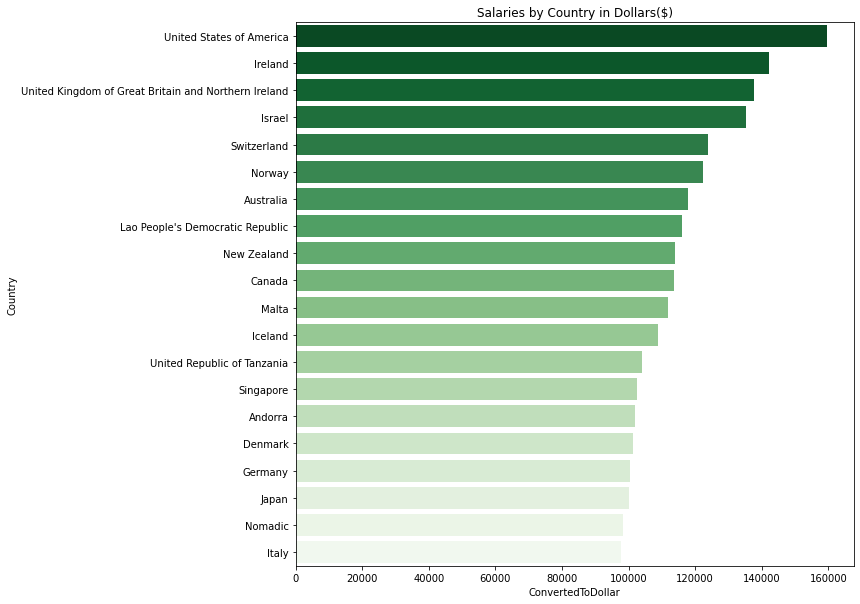

In [99]:
country_df = real_data[["Country", "ConvertedToDollar"]].groupby("Country").agg(np.mean).sort_values("ConvertedToDollar", ascending=False)
plt.figure(figsize=(10, 10))
plt.title("Salaries by Country in Dollars($)")
sns.barplot(y=country_df.index[:20], x=country_df["ConvertedToDollar"][:20], palette="Greens_r")
plt.show()

可以看出，最高的平均薪酬在阿美，能平均获得近 160,000 美元。